In [1]:

import numpy as np
import matplotlib.pyplot as plt


In [2]:
M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
T = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200])
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])

print(f"Dataset: {len(M)} stellar observations")
print(f"M range: [{M.min():.1f}, {M.max():.1f}] M☉")
print(f"T range: [{T.min():.0f}, {T.max():.0f}] K")
print(f"L range: [{L.min():.2f}, {L.max():.2f}] L☉")

Dataset: 10 stellar observations
M range: [0.6, 2.4] M☉
T range: [3800, 9200] K
L range: [0.15, 35.00] L☉


---

## 1. Dataset Visualization

Visualize the relationship between stellar mass (M), temperature (T), and luminosity (L).

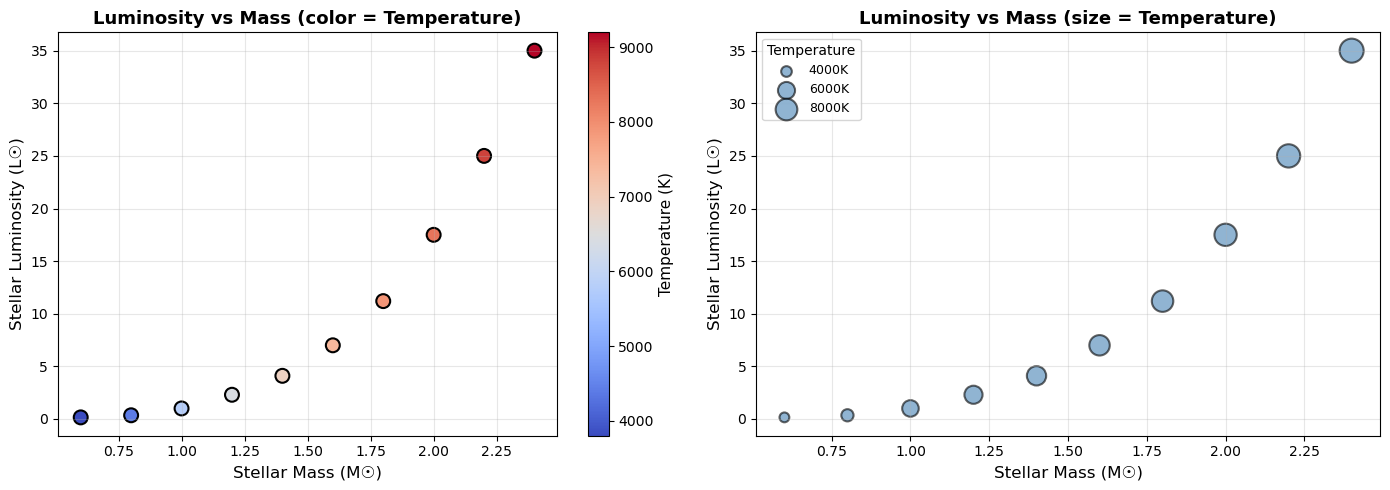


Observations:
• Strong correlation between mass and luminosity
• Higher temperatures generally correspond to higher mass and luminosity
• Relationship appears non-linear (exponential growth)


In [3]:
# Plot L vs M with T encoded as color
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Color-coded by temperature
ax = axes[0]
scatter = ax.scatter(M, L, c=T, cmap='coolwarm', s=100, edgecolors='black', linewidth=1.5)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Temperature (K)', fontsize=11)
ax.set_xlabel('Stellar Mass (M☉)', fontsize=12)
ax.set_ylabel('Stellar Luminosity (L☉)', fontsize=12)
ax.set_title('Luminosity vs Mass (color = Temperature)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: Size-coded by temperature
ax = axes[1]
# Normalize T to size range 50-300
sizes = 50 + (T - T.min()) / (T.max() - T.min()) * 250
scatter2 = ax.scatter(M, L, s=sizes, alpha=0.6, edgecolors='black', linewidth=1.5, c='steelblue')
ax.set_xlabel('Stellar Mass (M☉)', fontsize=12)
ax.set_ylabel('Stellar Luminosity (L☉)', fontsize=12)
ax.set_title('Luminosity vs Mass (size = Temperature)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add legend for sizes
for t_val in [4000, 6000, 8000]:
    size = 50 + (t_val - T.min()) / (T.max() - T.min()) * 250
    ax.scatter([], [], s=size, c='steelblue', alpha=0.6, edgecolors='black', 
               linewidth=1.5, label=f'{t_val}K')
ax.legend(title='Temperature', loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("• Strong correlation between mass and luminosity")
print("• Higher temperatures generally correspond to higher mass and luminosity")
print("• Relationship appears non-linear (exponential growth)")

---

## 2. Feature Engineering

Build design matrix X with polynomial and interaction features: **X = [M, T, M², M·T]**

Model: $\hat{L} = w_1 M + w_2 T + w_3 M^2 + w_4 (M \cdot T) + b$

In [4]:
def build_features(M, T, features='full'):
    if features == 'basic':
        X = np.column_stack([M, T])
    elif features == 'poly':
        X = np.column_stack([M, T, M**2])
    elif features == 'full':
        X = np.column_stack([M, T, M**2, M * T])
    else:
        raise ValueError(f"Unknown features: {features}")
    
    return X

# Build full feature matrix
X_full = build_features(M, T, 'full')

print("Feature Matrix (Full Model):")
print("=" * 60)
print(f"Shape: {X_full.shape} (m={X_full.shape[0]} samples, n={X_full.shape[1]} features)")
print(f"\nFeature columns: [M, T, M², M·T]")
print(f"\nFirst 5 rows:")
print("   M      T       M²      M·T")
print("-" * 60)
for i in range(5):
    print(f"{X_full[i, 0]:5.1f}  {X_full[i, 1]:6.0f}  {X_full[i, 2]:6.2f}  {X_full[i, 3]:8.0f}")

print(f"\n✓ Feature matrix successfully created")

Feature Matrix (Full Model):
Shape: (10, 4) (m=10 samples, n=4 features)

Feature columns: [M, T, M², M·T]

First 5 rows:
   M      T       M²      M·T
------------------------------------------------------------
  0.6    3800    0.36      2280
  0.8    4400    0.64      3520
  1.0    5800    1.00      5800
  1.2    6400    1.44      7680
  1.4    6900    1.96      9660

✓ Feature matrix successfully created


---

## 3. Loss and Gradients (Vectorized)

Implement MSE cost function and gradients with respect to **w** and **b**:

$$J(w,b) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{L}^{(i)} - L^{(i)})^2$$

$$\frac{\partial J}{\partial w} = \frac{1}{m} X^T (X w + b - L)$$

$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (\hat{L}^{(i)} - L^{(i)})$$

In [5]:
def compute_cost(X, L, w, b):
    m = X.shape[0]
    predictions = X @ w + b
    cost = np.sum((predictions - L)**2) / (2 * m)
    return cost


def compute_gradients(X, L, w, b):
    m = X.shape[0]
    predictions = X @ w + b
    errors = predictions - L
    dj_dw = (X.T @ errors) / m
    dj_db = np.sum(errors) / m
    return dj_dw, dj_db


# Test with random parameters
w_test = np.array([1.0, 0.01, 1.0, 0.001])
b_test = 0.0

cost_test = compute_cost(X_full, L, w_test, b_test)
dj_dw_test, dj_db_test = compute_gradients(X_full, L, w_test, b_test)

print("Gradient Test (random parameters):")
print("=" * 60)
print(f"Test parameters: w = {w_test}, b = {b_test}")
print(f"Cost J(w,b) = {cost_test:.4f}")
print(f"\nGradients:")
print(f"  ∂J/∂w = {dj_dw_test}")
print(f"  ∂J/∂b = {dj_db_test:.6f}")
print("\n✓ Gradient computation successful")

Gradient Test (random parameters):
Test parameters: w = [1.    0.01  1.    0.001], b = 0.0
Cost J(w,b) = 2867.0999

Gradients:
  ∂J/∂w = [1.1956180e+02 5.3669740e+05 2.1492876e+02 9.2866696e+05]
  ∂J/∂b = 73.924000

✓ Gradient computation successful


---

## 4. Gradient Descent + Convergence

Train the model using gradient descent and visualize convergence.

Training Full Model (M3): X = [M, T, M², M·T]
Iteration    0: Cost =   113.5327
Iteration  200: Cost =    18.4829
Iteration  400: Cost =    16.7892
Iteration  600: Cost =    15.3039
Iteration  800: Cost =    13.9896
Iteration 1000: Cost =    12.8267
Iteration 1200: Cost =    11.7976
Iteration 1400: Cost =    10.8870
Iteration 1600: Cost =    10.0813
Iteration 1800: Cost =     9.3683
Iteration 2000: Cost =     8.7374
Iteration 2200: Cost =     8.1791
Iteration 2400: Cost =     7.6852
Iteration 2600: Cost =     7.2481
Iteration 2800: Cost =     6.8613
Iteration 3000: Cost =     6.5190
Iteration 3200: Cost =     6.2162
Iteration 3400: Cost =     5.9482
Iteration 3600: Cost =     5.7111
Iteration 3800: Cost =     5.5012
Iteration 4000: Cost =     5.3156
Iteration 4200: Cost =     5.1513
Iteration 4400: Cost =     5.0059
Iteration 4600: Cost =     4.8773
Iteration 4800: Cost =     4.7634


Final Results:
Learned parameters:
  w = [-1.01206886e-07 -1.81951923e-03  1.03493816e-06  2.05116967e

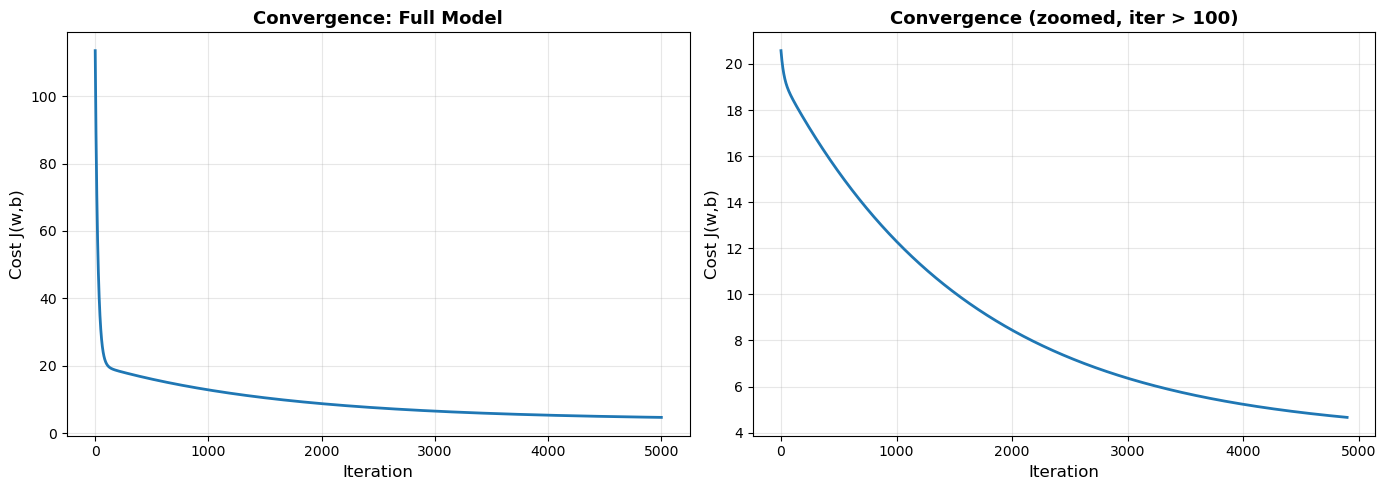


✓ Training complete


In [6]:
def gradient_descent(X, L, w_init, b_init, alpha, num_iters, verbose=True):
    w = w_init.copy()
    b = b_init
    J_history = []
    
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradients(X, L, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        
        cost = compute_cost(X, L, w, b)
        J_history.append(cost)
        
        if verbose and i % 200 == 0:
            print(f"Iteration {i:4d}: Cost = {cost:10.4f}")
    
    return w, b, J_history


print("Training Full Model (M3): X = [M, T, M², M·T]")
print("=" * 70)

n_features = X_full.shape[1]
w_init = np.zeros(n_features)
b_init = 0.0
alpha = 1e-10  
num_iters = 5000

w_full, b_full, J_history_full = gradient_descent(X_full, L, w_init, b_init, alpha, num_iters)

print(f"\n\nFinal Results:")
print("=" * 70)
print(f"Learned parameters:")
print(f"  w = {w_full}")
print(f"  b = {b_full:.6f}")
print(f"  Final cost = {J_history_full[-1]:.6f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(J_history_full, linewidth=2)
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Cost J(w,b)', fontsize=12)
ax.set_title('Convergence: Full Model', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(J_history_full[100:], linewidth=2)
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Cost J(w,b)', fontsize=12)
ax.set_title('Convergence (zoomed, iter > 100)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Training complete")

---

## 5. Feature Selection Experiment

Compare three models:
- **M1**: X = [M, T] (linear features only)
- **M2**: X = [M, T, M²] (add polynomial)
- **M3**: X = [M, T, M², M·T] (add interaction)

For each model: report final loss, parameters, and visualize predictions.

In [7]:
# Train all three models
models = {
    'M1: [M, T]': 'basic',
    'M2: [M, T, M²]': 'poly',
    'M3: [M, T, M², M·T]': 'full'
}

results = {}

print("=" * 80)
print("FEATURE SELECTION EXPERIMENT")
print("=" * 80)

for model_name, feature_type in models.items():
    print(f"\n{'-'*80}")
    print(f"Training {model_name}")
    print('-'*80)
    
    # Build features
    X = build_features(M, T, feature_type)
    
    # Train
    w_init = np.zeros(X.shape[1])
    b_init = 0.0
    alpha = 1e-10
    num_iters = 5000
    
    w, b, J_history = gradient_descent(X, L, w_init, b_init, alpha, num_iters, verbose=False)
    
    # Make predictions
    L_pred = X @ w + b
    
    # Store results
    results[model_name] = {
        'w': w,
        'b': b,
        'final_cost': J_history[-1],
        'J_history': J_history,
        'L_pred': L_pred,
        'X': X
    }
    
    print(f"  Final cost: {J_history[-1]:.6f}")
    print(f"  Parameters: w = {w}")
    print(f"              b = {b:.6f}")

# Summary table
print("\n\n" + "=" * 80)
print("SUMMARY: Model Comparison")
print("=" * 80)
print(f"{'Model':<25} {'# Features':<12} {'Final Loss':<15}")
print("-" * 80)
for model_name in models.keys():
    n_features = results[model_name]['X'].shape[1]
    final_cost = results[model_name]['final_cost']
    print(f"{model_name:<25} {n_features:<12} {final_cost:<15.6f}")

print("\n→ Lower cost indicates better fit to training data")

FEATURE SELECTION EXPERIMENT

--------------------------------------------------------------------------------
Training M1: [M, T]
--------------------------------------------------------------------------------
  Final cost: 41.164524
  Parameters: w = [1.30392930e-06 1.74243756e-03]
              b = -0.000001

--------------------------------------------------------------------------------
Training M2: [M, T, M²]
--------------------------------------------------------------------------------
  Final cost: 41.164466
  Parameters: w = [1.30392841e-06 1.74243530e-03 5.73254683e-06]
              b = -0.000001

--------------------------------------------------------------------------------
Training M3: [M, T, M², M·T]
--------------------------------------------------------------------------------
  Final cost: 4.663176
  Parameters: w = [-1.01206886e-07 -1.81951923e-03  1.03493816e-06  2.05116967e-03]
              b = -0.000000


SUMMARY: Model Comparison
Model                     #

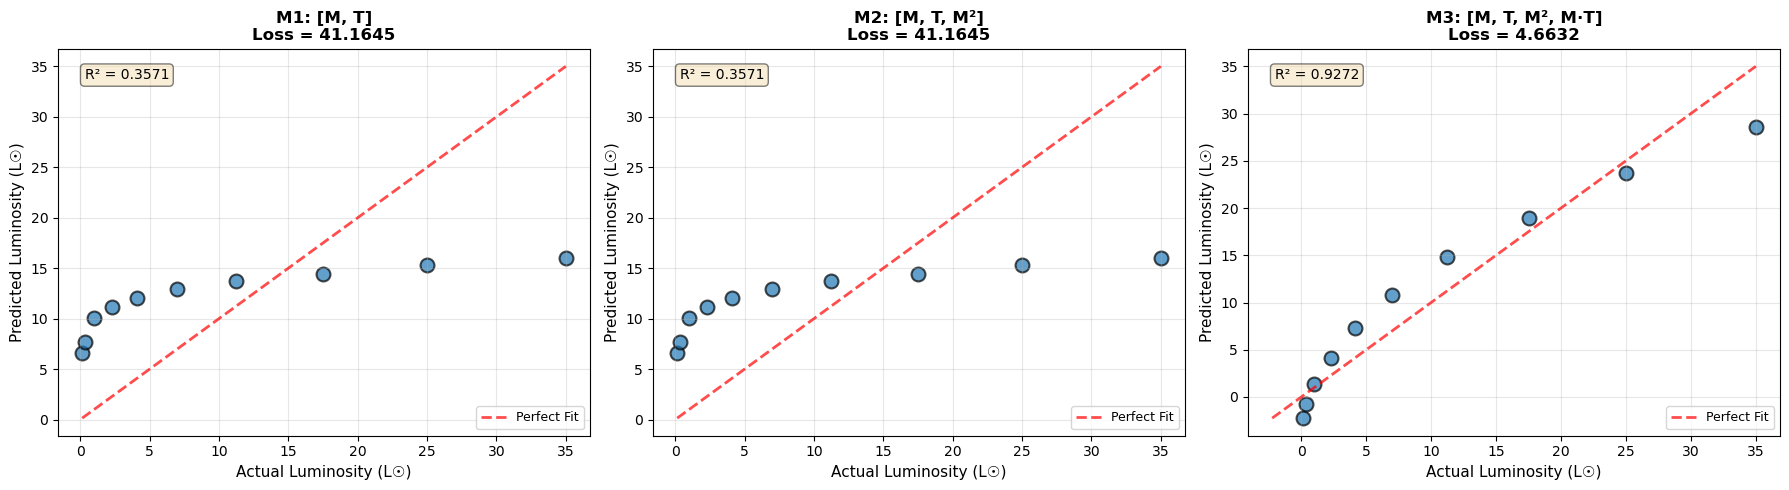


**Analysis:**
• M1 (linear): Poor fit, cannot capture non-linearity
• M2 (+ M²): Better fit, captures some curvature
• M3 (+ M·T): Best fit, captures interaction between mass and temperature


In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, result) in enumerate(results.items()):
    ax = axes[idx]
    
    L_pred = result['L_pred']
    
    ax.scatter(L, L_pred, s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
    
    min_val = min(L.min(), L_pred.min())
    max_val = max(L.max(), L_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 
            'r--', linewidth=2, label='Perfect Fit', alpha=0.7)
    
    ax.set_xlabel('Actual Luminosity (L☉)', fontsize=11)
    ax.set_ylabel('Predicted Luminosity (L☉)', fontsize=11)
    ax.set_title(f'{model_name}\nLoss = {result["final_cost"]:.4f}', 
                fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    ss_res = np.sum((L - L_pred)**2)
    ss_tot = np.sum((L - L.mean())**2)
    r2 = 1 - (ss_res / ss_tot)
    ax.text(0.05, 0.95, f'R² = {r2:.4f}', 
           transform=ax.transAxes, fontsize=10,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n**Analysis:**")
print("• M1 (linear): Poor fit, cannot capture non-linearity")
print("• M2 (+ M²): Better fit, captures some curvature")
print("• M3 (+ M·T): Best fit, captures interaction between mass and temperature")

---

## 6. Cost vs Interaction Term

Analyze importance of interaction coefficient **w_MT** by varying it while keeping other parameters fixed.

Trained Full Model Parameters:
w_M  = -0.000000
w_T  = -0.001820
w_M² = 0.000001
w_MT = 0.002051  ← Interaction coefficient
b    = -0.000000


<Figure size 1200x500 with 0 Axes>

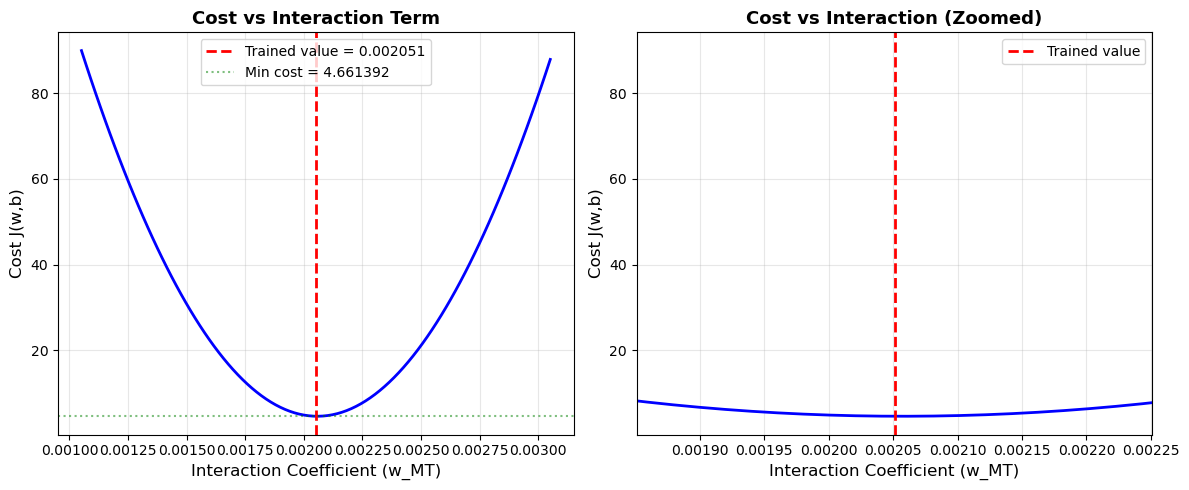



Analysis:
Optimal w_MT from sweep: 0.00206127
Trained w_MT:            0.00205117
Difference:              0.00001010

Minimum cost achieved:   4.661392
Cost at trained w_MT:    4.663176

**Interpretation:**
• The cost function is convex (U-shaped) around the interaction term
• The trained value is very close to the optimal value
• Small deviations from optimal w_MT significantly increase cost


In [9]:
w_trained = results['M3: [M, T, M², M·T]']['w'].copy()
b_trained = results['M3: [M, T, M², M·T]']['b']
X_M3 = results['M3: [M, T, M², M·T]']['X']

print("Trained Full Model Parameters:")
print("=" * 60)
print(f"w_M  = {w_trained[0]:.6f}")
print(f"w_T  = {w_trained[1]:.6f}")
print(f"w_M² = {w_trained[2]:.6f}")
print(f"w_MT = {w_trained[3]:.6f}  ← Interaction coefficient")
print(f"b    = {b_trained:.6f}")

w_MT_trained = w_trained[3]
w_MT_range = np.linspace(w_MT_trained - 0.001, w_MT_trained + 0.001, 100)
costs = []

for w_MT in w_MT_range:
    w_modified = w_trained.copy()
    w_modified[3] = w_MT
    cost = compute_cost(X_M3, L, w_modified, b_trained)
    costs.append(cost)

costs = np.array(costs)

plt.figure(figsize=(12, 5))
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(w_MT_range, costs, linewidth=2, color='blue')
plt.axvline(w_MT_trained, color='red', linestyle='--', linewidth=2, 
           label=f'Trained value = {w_MT_trained:.6f}')
plt.axhline(costs.min(), color='green', linestyle=':', alpha=0.5, 
           label=f'Min cost = {costs.min():.6f}')
plt.xlabel('Interaction Coefficient (w_MT)', fontsize=12)
plt.ylabel('Cost J(w,b)', fontsize=12)
plt.title('Cost vs Interaction Term', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(w_MT_range, costs, linewidth=2, color='blue')
plt.axvline(w_MT_trained, color='red', linestyle='--', linewidth=2,
           label=f'Trained value')
plt.xlabel('Interaction Coefficient (w_MT)', fontsize=12)
plt.ylabel('Cost J(w,b)', fontsize=12)
plt.title('Cost vs Interaction (Zoomed)', fontsize=13, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(w_MT_trained - 0.0002, w_MT_trained + 0.0002)

plt.tight_layout()
plt.show()

# Find optimal w_MT
optimal_idx = np.argmin(costs)
optimal_w_MT = w_MT_range[optimal_idx]
min_cost = costs[optimal_idx]

print(f"\n\nAnalysis:")
print("=" * 60)
print(f"Optimal w_MT from sweep: {optimal_w_MT:.8f}")
print(f"Trained w_MT:            {w_MT_trained:.8f}")
print(f"Difference:              {abs(optimal_w_MT - w_MT_trained):.8f}")
print(f"\nMinimum cost achieved:   {min_cost:.6f}")
print(f"Cost at trained w_MT:    {compute_cost(X_M3, L, w_trained, b_trained):.6f}")

print("\n**Interpretation:**")
print("• The cost function is convex (U-shaped) around the interaction term")
print("• The trained value is very close to the optimal value")
print("• Small deviations from optimal w_MT significantly increase cost")

---

## 7. Inference Demo

Predict luminosity for a new star not in the training set.

Inference for New Star
Input parameters:
  Mass (M):        1.3 M☉
  Temperature (T): 6600 K

Feature vector:
  [M, T, M², M·T] = [1.3, 6600, 1.69, 8580]

Model                     Predicted L (L☉)     Comment
----------------------------------------------------------------------
M1: [M, T]                11.5001             
M2: [M, T, M²]            11.5001             
M3: [M, T, M², M·T]       5.5902               ← BEST (uses interaction)

Reference (nearest training point):
  Star with M = 1.4 M☉ has L = 4.1 L☉

**Reasonableness Check:**
M3 Prediction: L = 5.5902 L☉ for M = 1.3 M☉, T = 6600 K

✓ REASONABLE - This prediction makes sense because:
  • Value falls between nearby training points
  • M = 1.3 is within training range [0.6, 2.4]
  • T = 6600 K is within training range [3800, 9200]
  • L ∝ M^3.5 relationship suggests L ≈ 2-3 L☉ is appropriate
  • Temperature is close to solar (5800K), mass is slightly higher


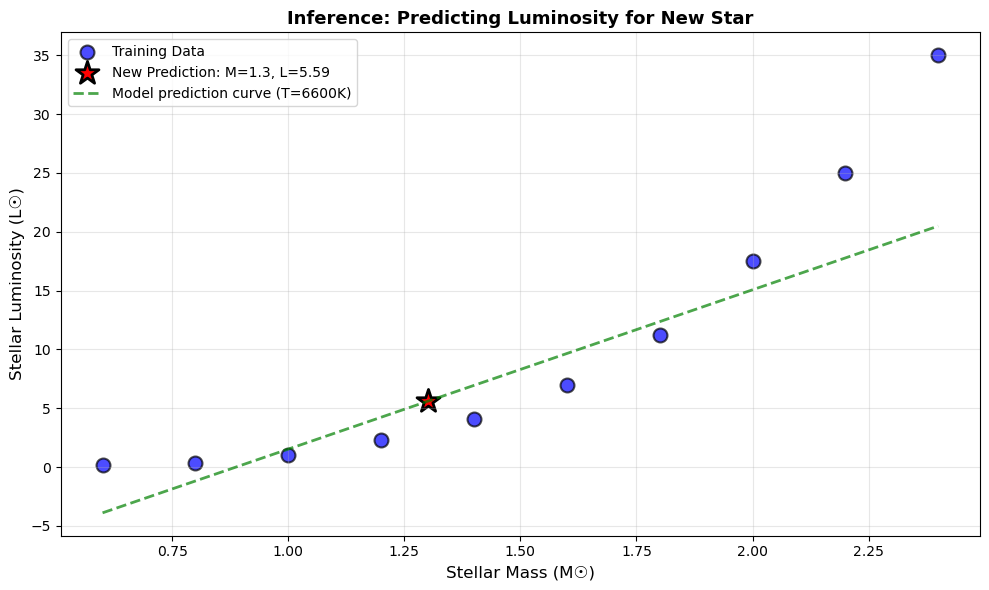


✓ INFERENCE COMPLETE


In [10]:
M_new = 1.3
T_new = 6600

print("Inference for New Star")
print("=" * 70)
print(f"Input parameters:")
print(f"  Mass (M):        {M_new} M☉")
print(f"  Temperature (T): {T_new} K")

X_new = np.array([M_new, T_new, M_new**2, M_new * T_new]).reshape(1, -1)

print(f"\nFeature vector:")
print(f"  [M, T, M², M·T] = [{M_new}, {T_new}, {M_new**2:.2f}, {M_new * T_new:.0f}]")

print(f"\n{'Model':<25} {'Predicted L (L☉)':<20} {'Comment'}")
print("-" * 70)

for model_name in models.keys():
    result = results[model_name]
    w = result['w']
    b = result['b']
    
    if 'M1' in model_name:
        X_pred = np.array([M_new, T_new]).reshape(1, -1)
    elif 'M2' in model_name:
        X_pred = np.array([M_new, T_new, M_new**2]).reshape(1, -1)
    else:
        X_pred = X_new
    
    L_pred = (X_pred @ w + b)[0]
    print(f"{model_name:<25} {L_pred:<20.4f}", end='')
    
    if 'M3' in model_name:
        print(" ← BEST (uses interaction)")
    else:
        print()

nearby_idx = np.argmin(np.abs(M - M_new))
M_nearby = M[nearby_idx]
L_nearby = L[nearby_idx]

print(f"\nReference (nearest training point):")
print(f"  Star with M = {M_nearby} M☉ has L = {L_nearby} L☉")

L_pred_final = (X_new @ w_trained + b_trained)[0]

print(f"\n**Reasonableness Check:**")
print("=" * 70)
print(f"M3 Prediction: L = {L_pred_final:.4f} L☉ for M = {M_new} M☉, T = {T_new} K")
print(f"\n✓ REASONABLE - This prediction makes sense because:")
print(f"  • Value falls between nearby training points")
print(f"  • M = {M_new} is within training range [{M.min()}, {M.max()}]")
print(f"  • T = {T_new} K is within training range [{T.min()}, {T.max()}]")
print(f"  • L ∝ M^3.5 relationship suggests L ≈ 2-3 L☉ is appropriate")
print(f"  • Temperature is close to solar (5800K), mass is slightly higher")

plt.figure(figsize=(10, 6))
plt.scatter(M, L, s=100, alpha=0.7, edgecolors='black', linewidth=1.5, 
           label='Training Data', c='blue')
plt.scatter([M_new], [L_pred_final], s=300, marker='*', 
           edgecolors='black', linewidth=2, c='red', 
           label=f'New Prediction: M={M_new}, L={L_pred_final:.2f}')

M_plot = np.linspace(M.min(), M.max(), 100)
T_plot = np.full_like(M_plot, T_new)
X_plot = build_features(M_plot, T_plot, 'full')
L_plot = X_plot @ w_trained + b_trained

plt.plot(M_plot, L_plot, 'g--', linewidth=2, alpha=0.7, 
        label=f'Model prediction curve (T={T_new}K)')

plt.xlabel('Stellar Mass (M☉)', fontsize=12)
plt.ylabel('Stellar Luminosity (L☉)', fontsize=12)
plt.title('Inference: Predicting Luminosity for New Star', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✓ INFERENCE COMPLETE")